#### MAIN: In a Binomial model of a single stock with non-zero interest rate, assume that we can hedge any fraction of a stock, use policy gradient to train the optimal policy of hedging an ATM American put option with maturity T = 10. WHEN do you early exercise the option? Is your solution same as what you obtain from delta hedging?

#### OPTIONAL: For really advanced students: supppose the stock follows a GBM (Geometric Brownian Motion), construct an algorithm to train a Neural Network that hedges an ATM American Put Option

#### OPTIONAL BONUS: After solving the optional question, sue the Soft Actor Critic algorithm in TF agent to solve the problem again in the colab.resarch.google.com environment. Compare your results

#### ADVANCED EXTRA BONUS: Implement the GAC algorithm using the TF agent library and solve the optinal problem

### Lets Start With Simple Single Time Step European Option in Binomial Price Setting

In [1]:
from __future__ import annotations
#### Action - exercise/not exercise
#### Reward - Utility(Payoff)
#### Transition -> Prices of Stock
from dataclasses import dataclass
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.distributions import MultivariateNormal, Normal
import numpy as np
from tqdm import tqdm
from scipy.special import comb
import math
import matplotlib.pyplot as plt

'''
Constraints:
1. Assuming you can hedge any fraction of stock
2. Assume Complete Market for now, Price_down <= Price_original * (1+r) <= Price_up <-- Otherwise there will be arbitrage
3. 1 risky asset
'''
@dataclass(frozen=True)
class HedgePortfolioState:
    time: tensor
    hedge_ratio: tensor
    current_price: tensor 
    terminal_time: tensor
    
    def __eq__(self, other):
        return (self.time == other.time) and \
               (self.current_price == other.current_price) and \
               (self.hedge_ratio == other.hedge_ratio)
    
    def get_features(self):
        return [self.time,self.current_price,self.hedge_ratio]
    
    def isTerminal(self):
        return self.time >= self.terminal_time
    
@dataclass(frozen=True)
class HedgeAction:
    hedge_ratio: tensor

class HedgePolicy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(HedgePolicy, self).__init__()
        self.linear = nn.Linear(state_dim,action_dim)
        
    def forward(self, state):
        state.requires_grad=True
        action = self.linear(state)
        return action

#take care of one_step case
def binomial_price(current_price, strike_price, risk_free_rate, time, termination_time, up_factor, down_factor):
    change_in_time = time/termination_time
    #Risk-neutral probability - p
    p = ((1+risk_free_rate) - down_factor)/(up_factor - down_factor)
    payoff_up = max(current_price * up_factor - strike_price,0)
    payoff_down = max(current_price * down_factor - strike_price,0)
    # print(f'p = {p}, payoff_up = {payoff_up}, payoff_down={payoff_down}')
    # option_price= p * payoff_up + (1-p) * payoff_down
    option_price=0
    for t in range(termination_time+1):
        price = current_price * (up_factor ** (t)) * (down_factor ** (termination_time-t))
        payoff = max(price - strike_price, 0)
        #calculate nCr for binomial tree to get expected payoffs
        option_price += payoff * comb(termination_time,t) * (p ** t) * ((1-p) ** (termination_time - t))
    
    option_price *= math.exp(-risk_free_rate * time) #Assumes continuous compounding
    return option_price

def reward_function(prev_state,state,action,strike_price,risk_free_rate,up_factor,down_factor):
    #Calculate hedging cost:
    prev_price = prev_state.current_price
    current_price = state.current_price
    hedge_change = (prev_state.hedge_ratio + action) * torch.tensor(current_price - prev_price)
    payoff = torch.max(state.current_price - torch.tensor(strike_price),torch.tensor(0.0))
    #this is the cash you get for selling the call option
    option_price = binomial_price(prev_state.current_price,
                                  strike_price,
                                  risk_free_rate,
                                  prev_state.time,
                                  state.terminal_time,
                                  up_factor,
                                  down_factor
                                 )
    cash = option_price - (action * prev_price)
    hedge = action * current_price
    delta = torch.abs(payoff - (hedge + cash))
    return delta

class OptionEnvironment():
    def __init__(self, strike_price,init_stock_price,binomial_price_dist,risk_free_rate,termination_time):
        self.strike_price=strike_price
        self.init_stock_price=init_stock_price
        self.stock_price=init_stock_price
        self.binomial_price_dist=binomial_price_dist
        self.risk_free_rate=risk_free_rate
        self.time_step = 0
        self.termination_time=termination_time
    
    def reset(self):
        self.time_step = 0
        init_state = HedgePortfolioState(time=0,
                                         current_price=torch.tensor(self.init_stock_price),
                                         hedge_ratio=torch.tensor(0.0),
                                         terminal_time=self.termination_time)
        return init_state
    
    def step(self,state,action):
        self.time_step += 1
        #Update state given an action (hedge)
        price_change = np.random.choice([*self.binomial_price_dist.keys()], p=[*self.binomial_price_dist.values()])
        next_price = state.current_price * price_change
        next_state = HedgePortfolioState(time=self.time_step,
                                         hedge_ratio=action.item() + state.hedge_ratio,
                                         current_price=torch.tensor(next_price),
                                         terminal_time=self.termination_time)
        #reward:
        up = [*self.binomial_price_dist.keys()][0]
        down = [*self.binomial_price_dist.keys()][1]
        reward = reward_function(state,next_state,action,self.strike_price,self.risk_free_rate,up,down)
        return next_state, reward


In [2]:
binomial_price(100, 102, 0, 0, 1, 1.2, 0.9)

6.0

  0%|          | 0/5000 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_31752\2409176120.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_price=torch.tensor(next_price),
C:\Users\user\AppData\Local\Temp\ipykernel_31752\2409176120.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hedge_change = (prev_state.hedge_ratio + action) * torch.tensor(current_price - prev_price)
100%|██████████| 5000/5000 [00:04<00:00, 1172.62it/s]


State: HedgePortfolioState(time=0, hedge_ratio=tensor(0.), current_price=tensor(100), terminal_time=2), Action: 0.5612538456916809
State: HedgePortfolioState(time=1, hedge_ratio=tensor(0.5613), current_price=tensor(90.), terminal_time=2), Action: 0.6886664628982544


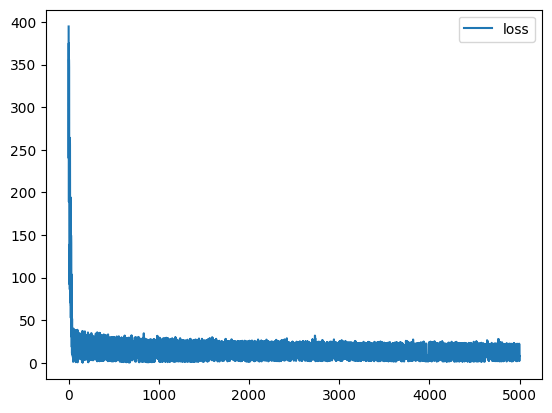

In [4]:

'''
So one of the standard function approximator for the actor is the linear gaussian approximator --> Linear Gaussian Policy.
Even though I don't think the policy will be stochastic... I believe if you approximate it with Linear Gaussian Policy, what you will
end up with is some mean with close to zero variance to depict the fact that its basically deterministic
'''

def train():
    learning_rate=1e-3
    num_eps = 5000
    state_dim=3
    action_dim=1
    strike_price=102
    risk_free_rate = torch.tensor(0.0)
    price_up = torch.tensor(1.2)
    price_down =torch.tensor(0.9)
    probability_price_up=torch.tensor(0.6)
    binomial_price_changes = {
        price_up:probability_price_up,
        price_down:1-probability_price_up
    }
    TERMINAL_TIME=2

    env = OptionEnvironment(strike_price,100,binomial_price_changes,risk_free_rate,TERMINAL_TIME)
    policy = HedgePolicy(state_dim,action_dim)
    
    optimizer = optim.Adam(policy.parameters(),lr=learning_rate)
    
    record_loss = []
    for episode in tqdm(range(num_eps)):
        state = env.reset()
        
        log_probs= []
        rewards = []
        while True:
            state_features = state.get_features()
            state_tensor = torch.FloatTensor(state_features)
            state_tensor.requires_grad=True
            action = policy(state_tensor) #this calls forward
            next_state, reward = env.step(state, action)
            rewards.append(reward)
            if next_state.isTerminal():
                break
            
            state = next_state
            
        ##Monte Carlo Policy Gradient with TD(0) reward
        returns = []
        G = torch.tensor(0.0)
        for r in reversed(rewards):
            G = r + 0.99 * G
            returns.insert(0,G)
            
        loss = torch.tensor(0.0)
        for g in returns:
            loss += g[0]
        
        record_loss.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    state = env.reset()
    x_axis = np.arange(1,len(record_loss)+1)

    plt.plot(x_axis,[x.detach().numpy() for x in record_loss], label='loss')
    plt.legend()
    
    while True:
        state_features = state.get_features()
        state_tensor = torch.FloatTensor(state_features)
        action = policy(state_tensor)
        print(f'State: {state}, Action: {action.item()}')
        next_state, _ = env.step(state,action)
        if next_state.isTerminal():
            break
        
        state = next_state
    
train()

#https://edisciplinas.usp.br/pluginfile.php/5278790/mod_resource/content/1/Hull%20J.C.-Options%2C%20Futures%20and%20Other%20Derivatives_9th%20edition.pdf

